In [1]:
pip install financepy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from financepy.utils import *
from financepy.products.equity import *

####################################################################
# FINANCEPY BETA Version 0.260 - This build:  22 Nov 2022 at 13:42 #
#      This software is distributed FREE & WITHOUT ANY WARRANTY    #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



# Question 1.a

In [3]:
valuation_date = Date(24,11,2022)
expiry_date = valuation_date.add_years(0.5)
expiry_date

24-MAY-2023

In [4]:
strike_price=100

In [5]:
call_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_CALL)

In [6]:
put_option = EquityVanillaOption(expiry_date, strike_price, OptionTypes.EUROPEAN_PUT)

In [7]:
stock_price = 100
volatility = 0.20
interest_rate = 0.05
dividend_yield = 0.0

In [8]:
discount_curve = DiscountCurveFlat(valuation_date, interest_rate)

In [9]:
dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)

In [10]:
model = BlackScholes(volatility)

In [11]:
call_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

6.8553162938833525

In [12]:
put_option.value(valuation_date, stock_price, discount_curve, dividend_curve, model)

4.406350170455643

In [13]:
print(call_option)

OBJECT TYPE: EquityVanillaOption
EXPIRY DATE: 24-MAY-2023
STRIKE PRICE: 100
OPTION TYPE VALUE: OptionTypes.EUROPEAN_CALL
NUMBER: 1.0


In [14]:
print(put_option)

OBJECT TYPE: EquityVanillaOption
EXPIRY DATE: 24-MAY-2023
STRIKE PRICE: 100
OPTION TYPE VALUE: OptionTypes.EUROPEAN_PUT
NUMBER: 1.0


# 1.b Option Delta & Risk Measures

In [15]:
call_option.delta(valuation_date, stock_price, discount_curve, dividend_curve, model)

0.597340042592488

Text(0, 0.5, 'Option Deltas')

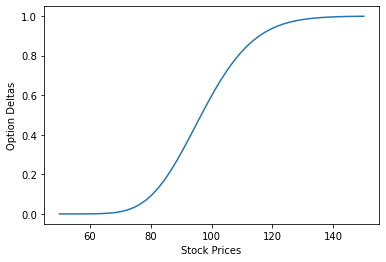

In [16]:
stock_prices = np.linspace(50,150)
deltas = call_option.delta(valuation_date, stock_prices, discount_curve, dividend_curve, model)
plt.plot(stock_prices, deltas)
plt.xlabel("Stock Prices")
plt.ylabel("Option Deltas")

# Other Sensitivities for Risk Measuring : Greeks

In [17]:
call_option.gamma(valuation_date, stock_price, discount_curve, dividend_curve, model)

0.02747870512774305

In [18]:
call_option.theta(valuation_date, stock_price, discount_curve, dividend_curve, model)

-8.13967542381688

In [19]:
call_option.rho(valuation_date, stock_price, discount_curve, dividend_curve, model)

26.22203430611273

In [20]:
call_option.vega(valuation_date, stock_price, discount_curve, dividend_curve, model)

27.25285275683009

In [21]:
value = call_option.value(valuation_date, stock_prices, discount_curve, dividend_curve, model)

Text(0, 0.5, 'Option Premium')

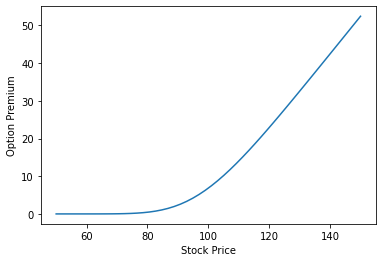

In [22]:
plt.plot(stock_prices, value)
plt.xlabel("Stock Price")
plt.ylabel("Option Premium")

   # 1.c Delta Hedging Under One Path

In [23]:
from datetime import date
import numpy as np

def OptionSim(K,S0,r,σ,µ,T,Nhedgepoints):
   
    valuation_date = Date(24,11,2022)
    expiry_date = valuation_date.add_years(T)
    dividend_yield = 0
    call_option2 = EquityVanillaOption(expiry_date, K, OptionTypes.EUROPEAN_CALL)
    discount_curve2 = DiscountCurveFlat(valuation_date, r)
    dividend_curve2 = DiscountCurveFlat(valuation_date, dividend_yield)
    
    dt = 1/Nhedgepoints
    S_t = np.zeros((Nhedgepoints)*T)
    S_t[0] = S0  
    Deltat = 0
    
    model = BlackScholes(σ)
    
    C = call_option2.value(valuation_date, S0,  discount_curve2, dividend_curve2, model) 
    Delta = call_option2.delta(valuation_date, S0, discount_curve2, dividend_curve2, model)
    b = C - Delta*S0 
        
    for i in range(1, (Nhedgepoints)*T):
        Deltat = Delta
        n = np.random.normal(0, 1) 
        S_t[i] = S_t[i-1]*np.exp((µ -0.5*σ ** 2)*dt+ σ*np.sqrt(dt)*n) 

        valuation_date = valuation_date.add_years(dt)
        discount_curve = DiscountCurveFlat(valuation_date, r)
        dividend_curve = DiscountCurveFlat(valuation_date, dividend_yield)
        Delta = call_option2.delta(valuation_date, S_t[i], discount_curve, dividend_curve, model)
        b = b*exp(r*dt)+(Deltat-Delta)*S_t[i]
        
        Hedge = b + Delta*S_t[-1]
        Deltat = Delta
        cashbalance = b
        Payoff = max(S_t[-1]-K,0)
        Error = Payoff - Hedge
        
             
    OptionSim.result = {"Terminal Stock Price is": S_t[-1], "Payoff of the call option is": Payoff, 'Delta at Maturity is': Deltat, 'Cash Balance worth': cashbalance,
                "Hedging Portfolio worth": Hedge, "Hedging error is": Error}
    
    return OptionSim.result
    

In [24]:
OptionSim(100,100,0.05,0.20,0.05,1,12)

{'Terminal Stock Price is': 84.07595169378963,
 'Payoff of the call option is': 0,
 'Delta at Maturity is': 0.0020276698491934475,
 'Cash Balance worth': 1.1512358796855278,
 'Hedging Portfolio worth': 1.3217141519772697,
 'Hedging error is': -1.3217141519772697}

# 1.d Delta Hedging Under N Paths

In [40]:
def hedgingError(K,S0,r,σ,µ,T,Nhedgepoints,Npaths):
    
    S_t = []
    Payoff = []
    Deltat = []
    Hedge = []
    Error = []

    for i in range(0,Npaths):
        OptionSim(K,S0,r,σ,µ,T,Nhedgepoints)
        S_t.append(OptionSim.result.get("Terminal Stock Price is"))
        Error.append(OptionSim.result.get("Hedging error is"))
        Payoff.append(OptionSim.result.get("Payoff of the call option is"))
        Deltat.append(OptionSim.result.get("Delta at Maturity is"))
        Hedge.append(OptionSim.result.get("Hedging Portfolio worth"))
    
    hedgingError.result = {"Error": Error,"Payoff": Payoff}
    plt.scatter(S_t, Hedge, s=1, color='red', label='Hedge')
    plt.scatter(S_t, Payoff, s=1, color='green', label='Pay Off')
    plt.xlabel('S(t)')
    plt.ylabel('Pay off / Hedge')
    plt.show()
    plt.scatter(S_t, Error, s=1, color='blue', label='Hedge')
    plt.xlabel('S(t)')
    plt.ylabel('Error')

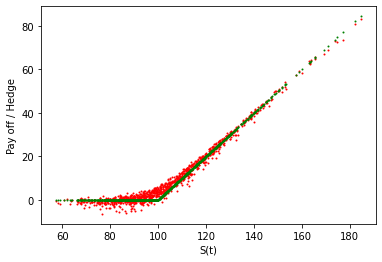

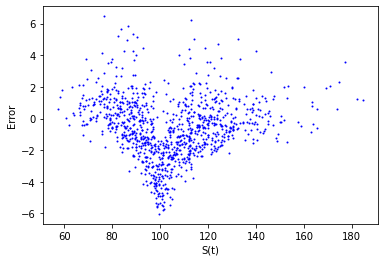

In [41]:
# for example, for 1000 paths, and monthly hedging, let's plot our hedging error function
hedgingError(100,100,0.05,0.20,0.05,1,12,1000)  # Monthly

# 1.e  Hedging Error Scatterplot

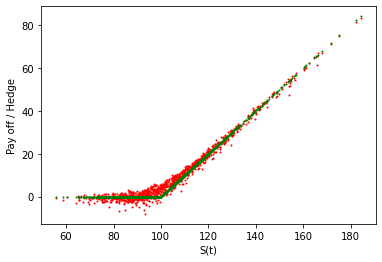

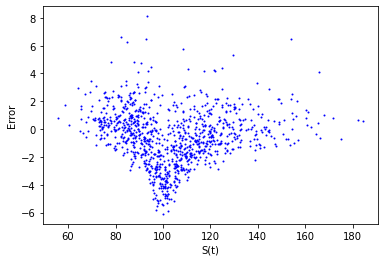

In [26]:
hedgingError(100,100,0.05,0.20,0.05,1,12,1000)  # Monthly

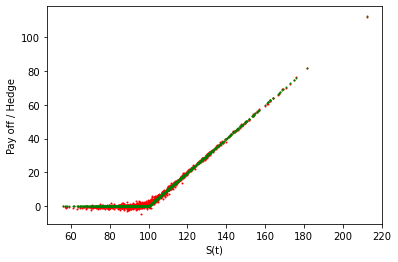

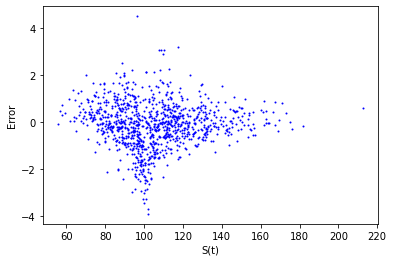

In [27]:
hedgingError(100,100,0.05,0.20,0.05,1,52,1000)  # Weekly

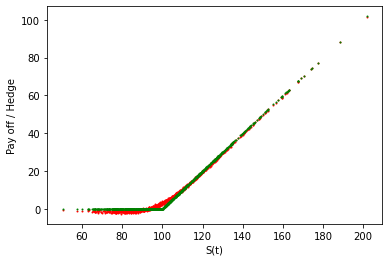

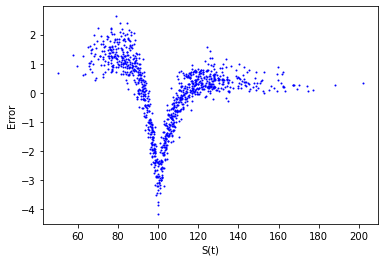

In [28]:
hedgingError(100,100,0.05,0.20,0.05,1,252,1000)   # Daily

1 - We notice that the bound1 - We notice that the interval containing the hedging error decreases when the hedging frequency is increased. 

2 - We also notice that the largest hedging differences occur when we have the largest gamma, i.e. at the money. At the money, gamma is the most important, it measures the frequency of rebalancing of the option's delta that it takes to be in the money. If we have to multiply the transactions to be in the money, we have a larger gamma and therefore a large error. In conclusion, largest differences
occur where largest Gamma is.

NB : Using 1000 paths, the time of execution of the code is important, especially for the daily hedging frequency. If we use 100 paths, all the computation become much faster, it can help to understand our conclusions more fastly. We put 1000 paths because the coursework asks us to put 1000 paths.

# 1.f Stastical Analysis of Error

In [29]:
import numpy as np
def errormeanfor(K,S0,r,σ,µ,T,Nhedgepoints,Npaths):
    hedgingError(K,S0,r,σ,µ,T,Nhedgepoints,Npaths)
    return [np.mean(hedgingError.result.get("Error")),(np.std(hedgingError.result.get("Error")))**2]
    

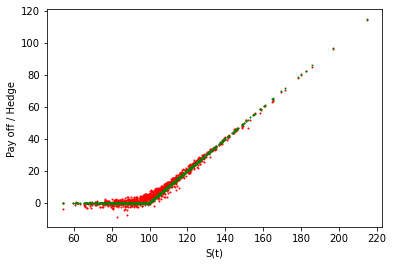

[-0.6334049656310919, 3.9530011073751696]


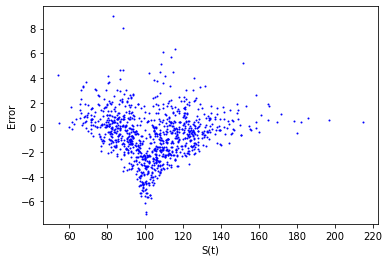

In [30]:
# N = 12
a = errormeanfor(100,100,0.05,0.20,0.05,1,12,1000)
print(a)

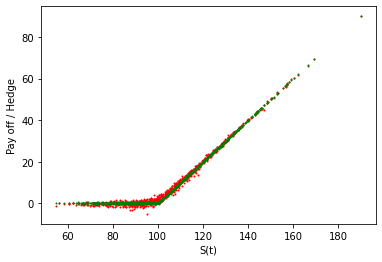

[-0.23085067877090668, 0.9336032443345456]


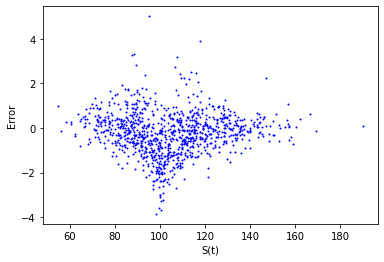

In [31]:
# N = 52
b = errormeanfor(100,100,0.05,0.20,0.05,1,52,1000)
print(b)

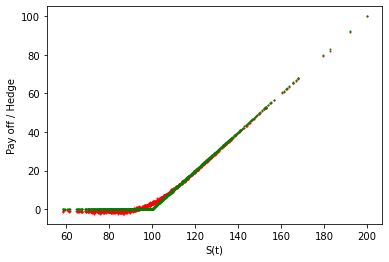

[0.02141168663949778, 1.4242594417146777]


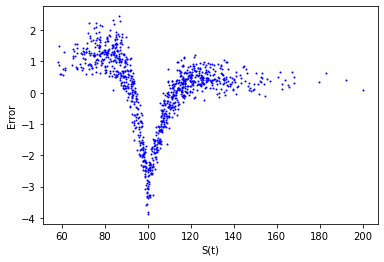

In [32]:
# N = 252
c = errormeanfor(100,100,0.05,0.20,0.05,1,252,1000)
print(c)

In [33]:
import pandas as pd
df = pd.DataFrame([a[0],b[0],c[0]],columns=["Mean of The Error"], index = ["Monthly","Weekly","Daily"])
df["Variance"]=[a[1],b[1],c[1]]
df

,Mean of The Error,Variance
Monthly,-0.633405,3.953001
Weekly,-0.230851,0.933603
Daily,0.021412,1.424259


Hence the interval containing the error shrinks when we increase the hedging frequency, the variance decreases as is measures the dispersion of our values.
We notice that our mean of error is centred on 0 and slightly equal to 0.

# 1.g Mean Absolute Error Value & Variance of Hedging Error for different Values of µ, 1000 Paths and N = 52 ( Weekly )

In [34]:
from sklearn.metrics import mean_absolute_error as mae
def errormeanabs(K,S0,r,σ,µ,T,Nhedgepoints,Npaths):
    hedgingError(K,S0,r,σ,µ,T,Nhedgepoints,Npaths)
    return [abs(np.mean(hedgingError.result.get("Error"))),(np.std(hedgingError.result.get("Error")))**2]

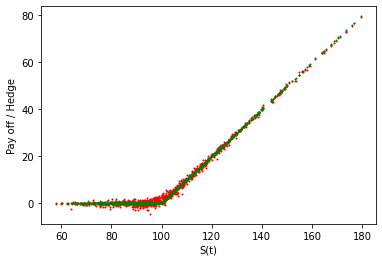

[0.06968053070645078, 0.9306427340910037]


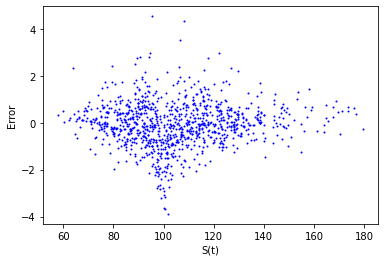

In [35]:
#µ = 2.5%
d = errormeanabs(100,100,0.025,0.20,0.05,1,52,1000)
print(d)

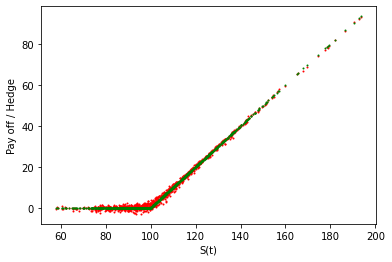

[0.08403417115190234, 0.9453581151425972]


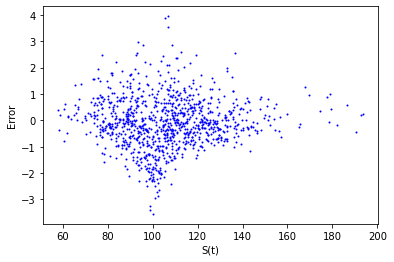

In [36]:
#µ = 5.0%
e = errormeanabs(100,100,0.05,0.20,0.05,1,52,1000)
print(e)

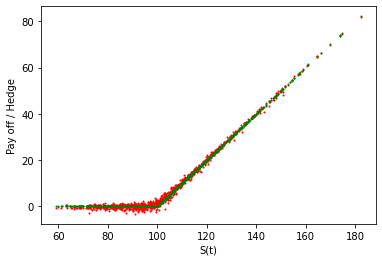

[0.13126883987248966, 0.8747128164004739]


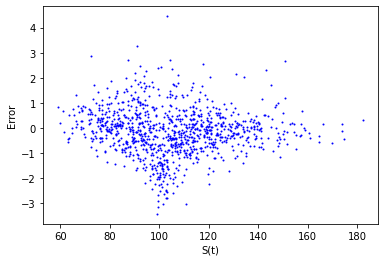

In [37]:
#µ = 7.5%
f = errormeanabs(100,100,0.075,0.20,0.05,1,52,1000)
print(f)

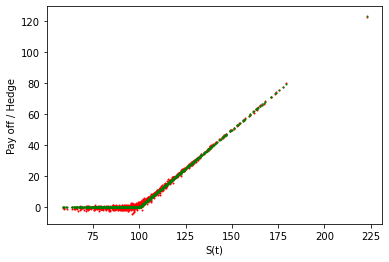

[0.22212643897535128, 0.9796838621788811]


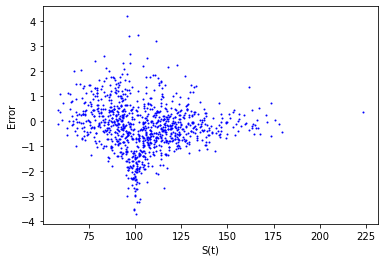

In [38]:
#µ = 10.0%
g = errormeanabs(100,100,0.1,0.20,0.05,1,52,1000)
print(g)

In [44]:
df2=pd.DataFrame([d[0],e[0],f[0],g[0]],columns=["Absolute Mean Error"],index=["µ = 2.5%","µ = 5.0%","µ = 7.5%","µ = 10.0%"])
df2["Variance"]=[d[1],e[1],f[1],g[1]]
df2

,Absolute Mean Error,Variance
µ = 2.5%,0.069681,0.930643
µ = 5.0%,0.084034,0.945358
µ = 7.5%,0.131269,0.874713
µ = 10.0%,0.222126,0.979684


For a higher µ, the absolute mean error increases, and it is coherent with the fact that the stock is a lognormal process which follow log-N(µ, Variance).